In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import os
import sklearn
import sys

from graphviz import Source
# from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

RESULTS_PATH = os.path.join('./results')

audio_results_metrics = pd.DataFrame()
dropped_results_metrics = pd.DataFrame()
filled_results_metrics = pd.DataFrame()

# Loading the data

In [3]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
audio_df = pd.read_csv(DATA_PATH+'audio_data.csv') # we probably wont use this until we know how to neural network
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')

In [4]:
song_dropped_df = song_dropped_df.drop(columns=['artist_name','track_name','instance_id'])
song_filled_df = song_filled_df.drop(columns=['artist_name','track_name'])

In [5]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i+=1

modes = dict({song_filled_df['mode'].unique()[0]:0, song_filled_df['mode'].unique()[1]:1})

song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])

In [6]:
# getting a list of all genre names
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

# getting a list of all features in each data frame
audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')

# Modeling

## Prepararation

Separating data from labels

In [7]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']

In [8]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))

1000
40560
50000


creating the initial splits

In [9]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)

Some methods do not work with the string labels, so we mapped the genre titles for each data set to unique integers

In [10]:
y_audio_nums = y_audio.copy()
y_audio_nums.replace(audio_genres, [x for x in range(10)], inplace=True)

y_dropped_nums = y_dropped.copy()
y_dropped_nums.replace(dropped_genres, [x for x in range(10)], inplace=True)

y_filled_nums = y_filled.copy()
y_filled_nums.replace(filled_genres,[x for x in range(10)], inplace=True)

In [11]:
# parameters:   pipe - model pipeline
#               params - dictionary of parameters specific to the model 
#               X,y - X and y for the data set that should be used for cross validating
#               label - label of the data set 
def run_grid_search(pipe, params, X, y, label):
    clf_GSCV = GridSearchCV(pipe, params)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

In [12]:
# defining the scaler we will be using
sc = StandardScaler()

sc.fit(X_audio_train)
sc.fit(X_audio_test)

sc.fit(X_dropped_train)
sc.fit(X_dropped_test)

sc.fit(X_filled_train)
sc.fit(X_filled_test)


StandardScaler()

## Training

### kNN Classifier

In [ ]:
knn = KNeighborsClassifier()

knn_pipe = Pipeline(steps=[('sc', sc),
                       ('knn', knn)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

neighbor_counts = [15, 20, 25, 30, 40, 50]

parameters = dict(knn__n_neighbors=neighbor_counts)

knn_results_df = pd.DataFrame()
knn_results_df = knn_results_df.append(
    run_grid_search(knn_pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(knn_pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(knn_pipe, parameters, X_filled, y_filled, 'Filled'))

knn_results_df.reset_index(inplace=True, drop=True)

In [ ]:
best_knn_audio = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                (knn_results_df.label == 'Audio')]

best_knn_dropped = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                  (knn_results_df.label == 'Dropped')]

best_knn_filled = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                 (knn_results_df.label == 'Filled')]


In [ ]:
print('best audio parameters:\n', '--n_neighbors--\n',
      best_knn_audio.param_knn__n_neighbors.values)

print('\n\nbest dropped parameters:\n', '--n_neighbors--\n',
      best_knn_dropped.param_knn__n_neighbors.values)

print('\n\nbest filled parameters:\n', '--n_neighbors--\n',
      best_knn_filled.param_knn__n_neighbors.values)


best audio parameters:
 --n_neighbors--
 [25]


best dropped parameters:
 --n_neighbors--
 [30]


best filled parameters:
 --n_neighbors--
 [50]


In [ ]:
knn_audio = KNeighborsClassifier(n_neighbors=best_knn_audio['param_knn__n_neighbors'].values[0]).fit(
    X_audio_train, y_audio_train)
knn_dropped = KNeighborsClassifier(
    n_neighbors=best_knn_dropped['param_knn__n_neighbors'].values[0]).fit(X_dropped_train, y_dropped_train)
knn_filled = KNeighborsClassifier(n_neighbors=best_knn_filled['param_knn__n_neighbors'].values[0]).fit(
    X_filled_train, y_filled_train)

y_pred_knn_audio = knn_audio.predict(X_audio_test)
y_pred_knn_dropped = knn_dropped.predict(X_dropped_test)
y_pred_knn_filled = knn_filled.predict(X_filled_test)

In [ ]:
knn_result_metrics_audio = pd.DataFrame(classification_report(
    y_audio_test, y_pred_knn_audio, output_dict=True))
knn_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_knn_dropped, output_dict=True))
knn_result_metrics_filled = pd.DataFrame(classification_report(
    y_filled_test, y_pred_knn_filled, output_dict=True))

knn_result_metrics_audio['model_type'] = 'knn'
knn_result_metrics_dropped['model_type'] = 'knn'
knn_result_metrics_filled['model_type'] = 'knn'

audio_results_metrics = knn_result_metrics_audio
dropped_results_metrics = knn_result_metrics_dropped
filled_results_metrics = knn_result_metrics_filled

### Logistic Regression

In [ ]:
sc = StandardScaler()
logreg = LogisticRegression()

logreg_pipe = Pipeline(steps=[('sc', sc),
                       ('logreg', logreg)])

solvers = ['lbfgs','liblinear','newton-cg']

max_iters = [100, 1000, 10000]

parameters = dict(logreg__solver=solvers,logreg__max_iter=max_iters)

logreg_results_df = pd.DataFrame()
logreg_results_df = logreg_results_df.append(
    run_grid_search(logreg_pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(logreg_pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(logreg_pipe, parameters, X_filled, y_filled, 'Filled'))

logreg_results_df.reset_index(inplace=True, drop=True)

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
best_logreg_audio = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                      (logreg_results_df.label == 'Audio')]

best_logreg_dropped = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                     (logreg_results_df.label == 'Dropped')]

best_logreg_filled = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                       (logreg_results_df.label == 'Filled')]

In [ ]:
print('\nbest audio parameters:\n', '--max_iter--\n', best_logreg_audio.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_audio.param_logreg__solver.values[0])

print('\n\nbest dropped parameters:\n', '--max_iter--\n', best_logreg_dropped.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_dropped.param_logreg__solver.values[0])

print('\n\nbest filled parameters:\n', '--max_iter--\n', best_logreg_filled.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_filled.param_logreg__solver.values[0])

best audio parameters:
 --max_iter--
 [100 100 1000 1000 10000 10000] 
--solver--
 lbfgs


best dropped parameters:
 --max_iter--
 [100 1000 10000] 
--solver--
 newton-cg


best filled parameters:
 --max_iter--
 [1000 10000] 
--solver--
 lbfgs


In [ ]:
logreg_audio = LogisticRegression(solver=best_logreg_audio['param_logreg__solver'].values[0], max_iter=best_logreg_audio['param_logreg__max_iter'].values[0]).fit(
    X_audio_train, y_audio_train)
logreg_dropped = LogisticRegression(
    solver=best_logreg_dropped['param_logreg__solver'].values[0], max_iter=best_logreg_dropped['param_logreg__max_iter'].values[0]).fit(X_dropped_train, y_dropped_train)
logreg_filled = LogisticRegression(solver=best_logreg_filled['param_logreg__solver'].values[0], max_iter=best_logreg_filled['param_logreg__max_iter'].values[0]).fit(
    X_filled_train, y_filled_train)

y_pred_logreg_audio = logreg_audio.predict(X_audio_test)
y_pred_logreg_dropped = logreg_dropped.predict(X_dropped_test)
y_pred_logreg_filled = logreg_filled.predict(X_filled_test)

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
logreg_result_metrics_audio = pd.DataFrame(classification_report(y_audio_test, y_pred_logreg_audio,
                                                          output_dict=True))
logreg_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_logreg_dropped,
    output_dict=True))
logreg_result_metrics_filled = pd.DataFrame(classification_report(y_filled_test, y_pred_logreg_filled,
                                                           output_dict=True))

logreg_result_metrics_audio['model_type'] = 'logreg'
logreg_result_metrics_dropped['model_type'] = 'logreg'
logreg_result_metrics_filled['model_type'] = 'logreg'

audio_results_metrics.append(logreg_result_metrics_audio)
dropped_results_metrics.append(logreg_result_metrics_dropped)
filled_results_metrics.append(logreg_result_metrics_filled)

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Audio
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        21
   classical       0.62      0.82      0.71        22
     country       0.10      0.04      0.06        23
       disco       0.00      0.00      0.00        27
      hiphop       0.23      0.38      0.29        13
        jazz       0.31      0.43      0.36        21
       metal       0.23      0.69      0.34        13
         pop       0.61      0.85      0.71        20
      reggae       0.21      0.33      0.26        15
        rock       0.33      0.08      0.13        25

    accuracy                           0.33       200
   macro avg       0.26      0.36      0.28       200
weighted avg       0.26      0.33      0.27       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.37      0.29      0.33      1199
       Anime       0.63      0.60      0.62      1273
       Blues       0.51      0.45      0.48      1217
   C

### Decision Trees

In [ ]:
tree = DecisionTreeClassifier()

tree_pipe = Pipeline(steps=[('sc', sc),
                            ('tree', tree)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

criterion = ['gini', 'entropy']
max_depth = [4, 6, 8, 10]

parameters = dict(
    tree__criterion=criterion,
    tree__max_depth=max_depth)

tree_results_df = pd.DataFrame()
tree_results_df = tree_results_df.append(
    run_grid_search(tree_pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(tree_pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(tree_pipe, parameters, X_filled, y_filled, 'Filled'))

tree_results_df.reset_index(inplace=True, drop=True)

In [ ]:
best_tree_audio = tree_results_df[(tree_results_df.rank_test_score == 1) &
                (tree_results_df.label == 'Audio')]

best_tree_dropped = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                  (tree_results_df.label == 'Dropped')]

best_tree_filled = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                    (tree_results_df.label == 'Filled')]

In [ ]:
print('best audio parameters:\n', '--criterion--\n',
      best_tree_audio.param_tree__criterion.values, '\n--max_depth--\n',
      best_tree_audio.param_tree__max_depth.values)

print('\n\nbest dropped parameters:\n', '--criterion--\n',
      best_tree_dropped.param_tree__criterion.values, '\n--max_depth--\n',
      best_tree_dropped.param_tree__max_depth.values)

print('\n\nbest filled parameters:\n', '--criterion--\n',
      best_tree_filled.param_tree__criterion.values, '\n--max_depth--\n',
      best_tree_filled.param_tree__max_depth.values)


best audio parameters:
 --criterion--
 ['entropy'] 
--max_depth--
 [6]


best dropped parameters:
 --criterion--
 ['entropy'] 
--max_depth--
 [10]


best filled parameters:
 --criterion--
 ['entropy'] 
--max_depth--
 [10]


In [ ]:
tree_audio = DecisionTreeClassifier(
    criterion=best_tree_audio['param_tree__criterion'].values[0],
    max_depth=best_tree_audio['param_tree__max_depth'].values[0]).fit(X_audio_train, y_audio_train)

tree_dropped = DecisionTreeClassifier(
    criterion=best_tree_dropped['param_tree__criterion'].values[0],
    max_depth=best_tree_dropped['param_tree__max_depth'].values[0]).fit(X_dropped_train, y_dropped_train)

tree_filled = DecisionTreeClassifier(
    criterion=best_tree_filled['param_tree__criterion'].values[0],
    max_depth=best_tree_filled['param_tree__max_depth'].values[0]).fit(X_filled_train, y_filled_train)

y_pred_audio = tree_audio.predict(X_audio_test)
y_pred_dropped = tree_dropped.predict(X_dropped_test)
y_pred_filled = tree_filled.predict(X_filled_test)

In [ ]:
tree_result_metrics_audio = pd.DataFrame(classification_report(
    y_audio_test, y_pred_audio, output_dict=True))
tree_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_dropped, output_dict=True))
tree_result_metrics_filled = pd.DataFrame(classification_report(
    y_filled_test, y_pred_filled, output_dict=True))

tree_result_metrics_audio['model_type'] = 'forest'
tree_result_metrics_dropped['model_type'] = 'forest'
tree_result_metrics_filled['model_type'] = 'forest'

audio_results_metrics.append(tree_result_metrics_audio)
dropped_results_metrics.append(tree_result_metrics_dropped)
filled_results_metrics.append(tree_result_metrics_filled)

,Alternative,Anime,Blues,Classical,Country,Electronic,Hip-Hop,Jazz,Rap,Rock,accuracy,macro avg,weighted avg,model_type
precision,0.292373,0.644526,0.428047,0.724109,0.339759,0.460967,0.287989,0.391892,0.286846,0.360092,0.400000,0.421660,0.421859,knn
recall,0.376792,0.579016,0.385837,0.574411,0.461690,0.252889,0.284404,0.192819,0.373710,0.512068,0.400000,0.399364,0.400000,knn
f1-score,0.329257,0.610017,0.405848,0.640631,0.391449,0.326602,0.286185,0.258467,0.324567,0.422839,0.400000,0.399586,0.400043,knn
support,1465.000000,1525.000000,1511.000000,1485.000000,1527.000000,1471.000000,1526.000000,1504.000000,1453.000000,1533.000000,0.400000,15000.000000,15000.000000,knn
precision,0.393586,0.711913,0.485305,0.808023,0.504517,0.544228,0.422062,0.454259,0.415724,0.482860,0.518467,0.522248,0.522532,forest
recall,0.368601,0.646557,0.448048,0.759596,0.475442,0.493542,0.346003,0.382979,0.505850,0.753425,0.518467,0.518004,0.518467,forest
f1-score,0.380684,0.677663,0.465933,0.783061,0.489548,0.517647,0.380266,0.415584,0.456380,0.588535,0.518467,0.515530,0.515845,forest
support,1465.000000,1525.000000,1511.000000,1485.000000,1527.000000,1471.000000,1526.000000,1504.000000,1453.000000,1533.000000,0.518467,15000.000000,15000.000000,forest


### Random Forest

In [ ]:
forest = RandomForestClassifier()

forest_pipe = Pipeline(steps=[('sc', sc),
                       ('forest', forest)])

n_estimators = [10, 50, 100, 200]
# We determined entropy was optimal from the decision tree modeling
criterion = ['entropy']
# We determined 10 was optimal from the decision tree modeling
max_depth = [10]

forest_parameters = dict(forest__n_estimators=n_estimators,
                  forest__criterion=criterion,
                  forest__max_depth=max_depth)

forest_results_df = pd.DataFrame()
forest_results_df = forest_results_df.append(
    run_grid_search(forest_pipe, forest_parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(forest_pipe, forest_parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(forest_pipe, forest_parameters, X_filled, y_filled, 'Filled'))

forest_results_df.reset_index(inplace=True, drop=True)

In [ ]:
best_forest_audio = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                      (forest_results_df.label == 'Audio')]

best_forest_dropped = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                        (forest_results_df.label == 'Dropped')]

best_forest_filled = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                       (forest_results_df.label == 'Filled')]

In [ ]:
print('best audio parameters:\n', '--n_estimators--\n', best_forest_audio.param_forest__n_estimators.values)
print('\n\nbest dropped parameters:\n', '--n_estimators--\n', best_forest_dropped.param_forest__n_estimators.values)
print('\n\nbest filled parameters:\n', '--n_estimators--\n', best_forest_filled.param_forest__n_estimators.values)

best audio parameters:
 --n_estimators--
 [200]


best dropped parameters:
 --n_estimators--
 [200]


best filled parameters:
 --n_estimators--
 [200]


In [ ]:
forest_audio = RandomForestClassifier(
    n_estimators=best_forest_audio['param_forest__n_estimators'].values[0],
    criterion=best_forest_audio['param_forest__criterion'].values[0],
    max_depth=best_forest_audio['param_forest__max_depth'].values[0]).fit(X_audio_train, y_audio_train)

forest_dropped = RandomForestClassifier(
    n_estimators=best_forest_dropped['param_forest__n_estimators'].values[0],
    criterion=best_forest_dropped['param_forest__criterion'].values[0],
    max_depth=best_forest_dropped['param_forest__max_depth'].values[0]).fit(X_dropped_train, y_dropped_train)

forest_filled = RandomForestClassifier(
    n_estimators=best_forest_filled['param_forest__n_estimators'].values[0],
    criterion=best_forest_filled['param_forest__criterion'].values[0],
    max_depth=best_forest_filled['param_forest__max_depth'].values[0]).fit(X_filled_train, y_filled_train)


y_pred_forest_audio = forest_audio.predict(X_audio_test)
y_pred_forest_dropped = forest_dropped.predict(X_dropped_test)
y_pred_forest_filled = forest_filled.predict(X_filled_test)

In [ ]:

forest_result_metrics_audio = pd.DataFrame(classification_report(y_audio_test, y_pred_forest_audio,
                      output_dict= True))
forest_result_metrics_dropped = pd.DataFrame(classification_report(y_dropped_test, y_pred_forest_dropped, output_dict=True))
forest_result_metrics_filled=pd.DataFrame(classification_report(y_filled_test, y_pred_forest_filled, output_dict = True))

forest_result_metrics_audio['model_type'] = 'forest'
forest_result_metrics_dropped['model_type'] = 'forest'
forest_result_metrics_filled['model_type'] = 'forest'

audio_results_metrics.concat(forest_result_metrics_audio)
dropped_results_metrics.concat(forest_result_metrics_dropped)
filled_results_metrics.concat(forest_result_metrics_filled)

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,accuracy,macro avg,weighted avg
precision,0.333333,0.772727,0.277778,0.600000,0.235294,0.269231,0.280000,0.680000,0.291667,0.388889,0.41,0.412892,0.433194
recall,0.238095,0.772727,0.217391,0.222222,0.307692,0.333333,0.538462,0.850000,0.466667,0.280000,0.41,0.422659,0.410000
f1-score,0.277778,0.772727,0.243902,0.324324,0.266667,0.297872,0.368421,0.755556,0.358974,0.325581,0.41,0.399180,0.401733
support,21.000000,22.000000,23.000000,27.000000,13.000000,21.000000,13.000000,20.000000,15.000000,25.000000,0.41,200.000000,200.000000


## Plotting the Results

12:42 running models

#### Result metrics data

In [ ]:
audio_results_metrics

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,accuracy,macro avg,weighted avg,model_type
precision,0.0,0.692308,0.200000,0.476190,0.238095,0.222222,0.347826,0.629630,0.172414,0.300000,0.375,0.327869,0.338252,knn
recall,0.0,0.818182,0.130435,0.370370,0.384615,0.285714,0.615385,0.850000,0.333333,0.120000,0.375,0.390803,0.375000,knn
f1-score,0.0,0.750000,0.157895,0.416667,0.294118,0.250000,0.444444,0.723404,0.227273,0.171429,0.375,0.343523,0.341979,knn
support,21.0,22.000000,23.000000,27.000000,13.000000,21.000000,13.000000,20.000000,15.000000,25.000000,0.375,200.000000,200.000000,knn


#### Writing results data frames to .csv files

In [ ]:
knn_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'knn_results.csv'),
    index=False)

tree_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'tree_results.csv'),
    index=False)

logreg_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'logreg_results.csv'),
    index=False)

forest_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'forest_results.csv'),
    index=False)

audio_results_metrics.to_csv(
    os.path.join(RESULTS_PATH, 'audio_results_metrics.csv'),
    index=False)

dropped_results_metrics.to_csv(
    os.path.join(RESULTS_PATH, 'dropped_results_metrics.csv'),
    index=False)

filled_results_metrics.to_csv(
    os.path.join(RESULTS_PATH, 'filled_results_metrics.csv'),
    index=False)

NameError: name 'knn_results_df' is not defined

#### Confusion Matrices

In [ ]:
def plot_confustion_matrices(models, plot_name):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    plot_confusion_matrix(
        models[0], X_audio_test, y_audio_test, ax=axs[0], cmap='magma')
    plot_confusion_matrix(
        models[1], X_dropped_test, y_dropped_test, ax=axs[1], cmap='magma')
    plot_confusion_matrix(
        models[2], X_filled_test, y_filled_test, ax=axs[2], cmap='magma')

    axs[0].set(title='Audio')
    axs[1].set(title='Dropped')
    axs[2].set(title='Filled')

    for i in range(3):
        axs[i].set_xticklabels(
            axs[i].get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        )
        axs[i].grid(False)

    plt.suptitle(
        f'Confusion matrices for {plot_name} models with optimal paramters',
        fontsize=16)

    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=0.9,
        top=0.8,
        wspace=0.2,
        hspace=0.4)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'confusion_matrices_' + plot_name + '.png'))

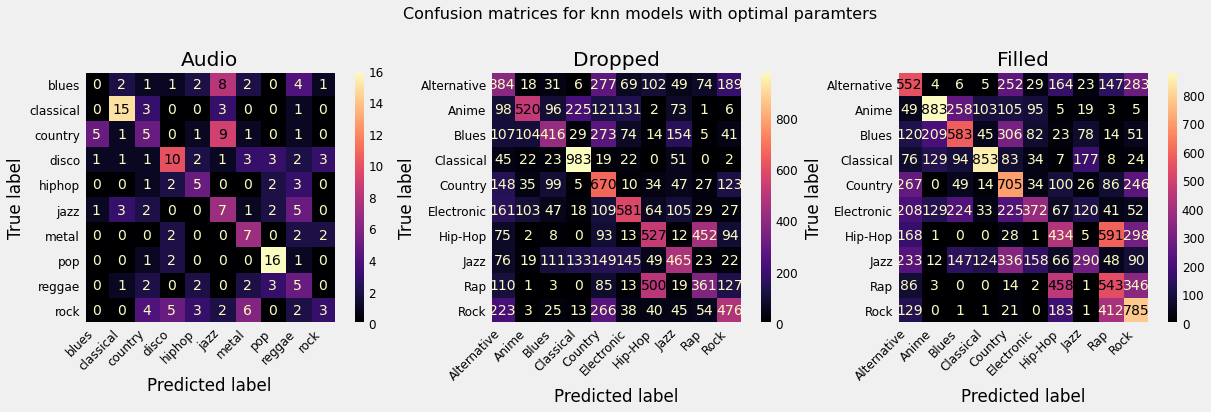

In [ ]:
plot_confustion_matrices([knn_audio, knn_dropped, knn_filled], 'knn')

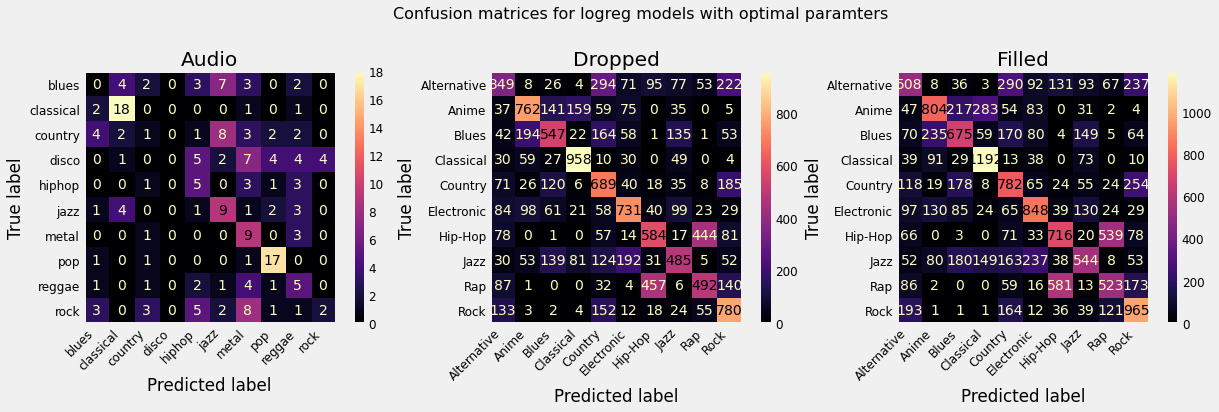

In [ ]:
plot_confustion_matrices(
    [logreg_audio, logreg_dropped, logreg_filled], 'logreg')

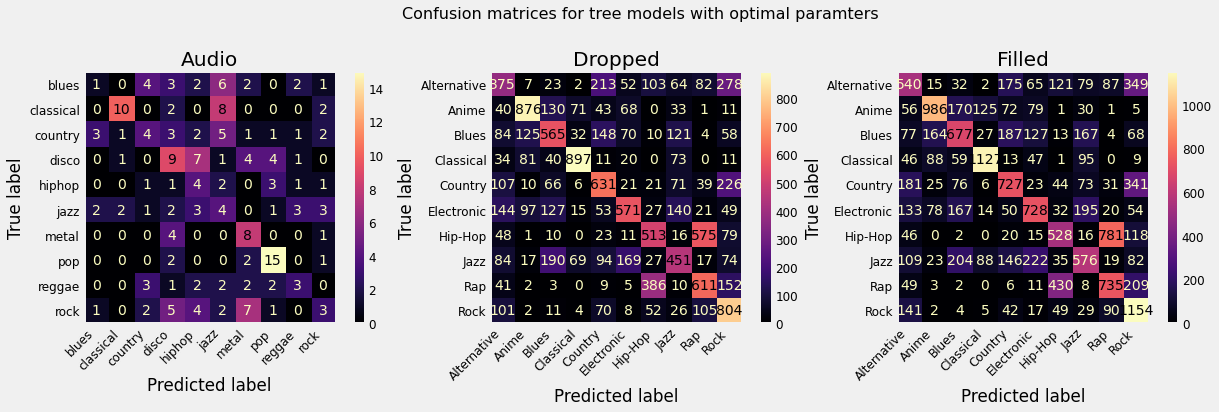

In [ ]:
plot_confustion_matrices([tree_audio, tree_dropped, tree_filled], 'tree')

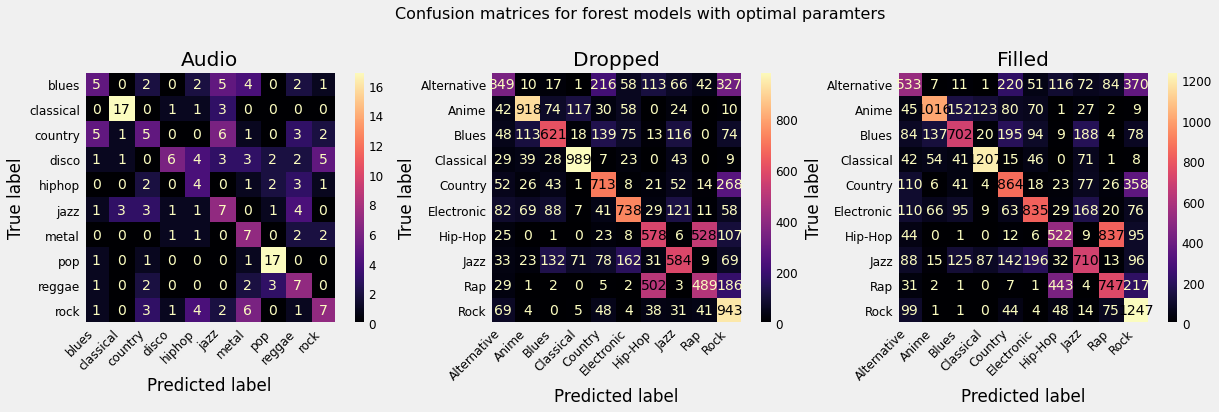

In [ ]:
plot_confustion_matrices(
    [forest_audio, forest_dropped, forest_filled], 'forest')


#### Decision Tree Diagrams

In [ ]:
dot_data = export_graphviz(
    tree_audio,
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)

out_file = os.path.join(RESULTS_PATH, "audio_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,50!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

True

In [ ]:
dot_data = export_graphviz(
    tree_dropped,
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(RESULTS_PATH, "dropped_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

True

In [ ]:
dot_data = export_graphviz(
    tree_filled,
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)
out_file = os.path.join(RESULTS_PATH, "filled_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

True

#### Learning Curves

In [ ]:
def plot_learning_curves(model, X, y, title=None, splits = [.05, .1, .15,.2, .25, .3, .35, .4], start_size = 5, plot_name = None, scale = 10):
    nrows = int(np.sqrt(len(splits)))
    ncols = int((len(splits)+1)/nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize = (18,8),sharey=True)
    i = 0
    X_scaled = X.copy()
    sc.fit(X_scaled)
    
    for split in splits:
        if nrows == 1:
            idx = i
        else:
            idx = (int(i / ncols), int(i % ncols))
        
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size = split)
        train_errors, val_errors, xs = [], [], []

        for m in range(start_size, len(X_train), scale):
            model.fit(X_train[:m ], y_train[:m ])
            y_train_predict = model.predict(X_train[:m ])
            y_val_predict = model.predict(X_val)
            train_errors.append(mean_squared_error(
                y_train[:m ], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))
            xs.append(m)

        axs[idx].set_title(f'test split size: {split}', fontsize = 14)
        axs[idx].plot(xs,np.sqrt(train_errors), 'r--.', linewidth=0.5, label="train", markersize=3)
        axs[idx].plot(xs,np.sqrt(val_errors), "b-", linewidth=2, label="test")
        axs[idx].legend(loc="upper right", fontsize=12)
        axs[idx].set_xlabel("Training set size", fontsize=12)
        axs[idx].set_ylabel("RMSE", fontsize=12)
        # axs[idx].set_ylim(np.sqrt(train_errors)[1], max(np.sqrt(val_errors)))
        i += 1
    fig.suptitle(title, fontsize = 16)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.4)
    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curves_' + plot_name + '.png'))

# plot_learning_curves(tree_audio, X_audio, y_audio_nums,
#                      'Learning curves for decision tree model: audio dataset')


# plot_learning_curves(tree_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for decision tree model: dropped dataset', plot_name='tree_dropped', scale=2000)


In [ ]:
def plot_learning_curve(model, X, y, title=None, plot_name=None, splits = 15):
    fig, ax = plt.subplots(1, 1, figsize = (5,4),sharey=True)
    train_sizes = np.linspace(0.05, 0.8, splits)
    train_sizes, train_mse, test_mse = learning_curve(model, X, y,
                                                    train_sizes=train_sizes,
                                                    scoring='neg_root_mean_squared_error',
                                                    cv=5, shuffle=True)

    train_scores = np.sqrt(np.abs(train_mse))
    test_scores = np.sqrt(np.abs(test_mse))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.set_title(f'test split size',fontsize = 14)
    ax.plot(train_sizes, train_scores_mean, 'o-',
            color="r", label="Training score", linewidth=1, markersize = 2)
    ax.plot(train_sizes, test_scores_mean, 'o-',
            color="b", label="Cross-validation score", linewidth=1, markersize=2)
    ax.set_xlabel("Training set size", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.legend(loc="best", fontsize = 12)

    fig.suptitle(title, fontsize = 16)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curve_' + plot_name + '.png'))

# plot_learning_curve(tree_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for decision tree model: dropped dataset')


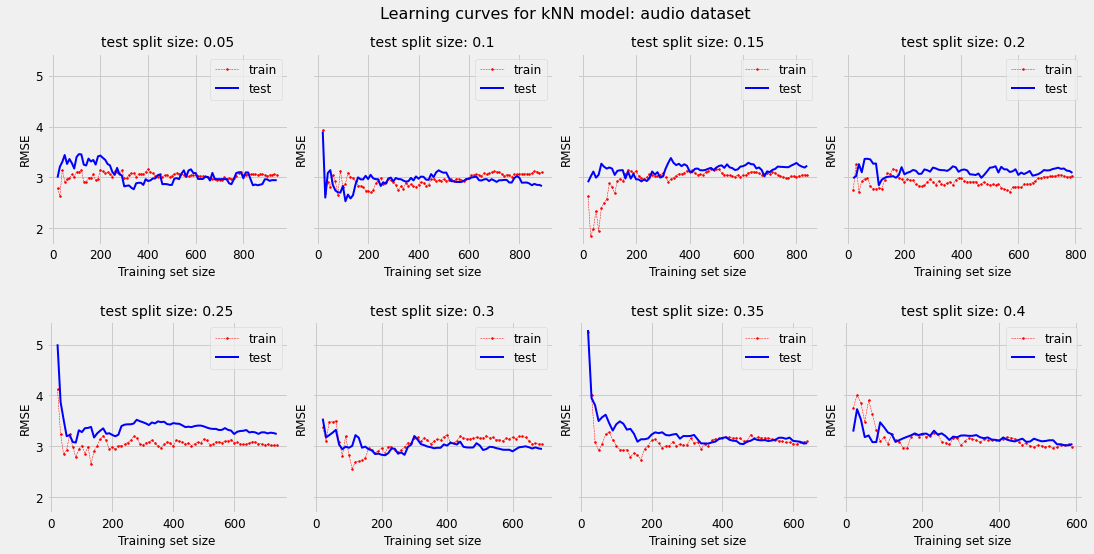

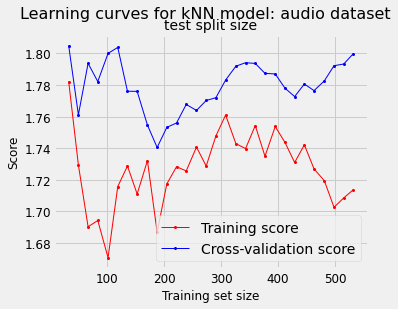

In [ ]:
plot_learning_curves(knn_audio, X_audio, y_audio_nums,
                     'Learning curves for kNN model: audio dataset', plot_name='knn_audio', start_size=best_knn_audio['param_knn__n_neighbors'].values[0])

plot_learning_curve(knn_audio, X_audio, y_audio_nums,'Learning curves for kNN model: audio dataset', plot_name='knn_audio', splits = 30)

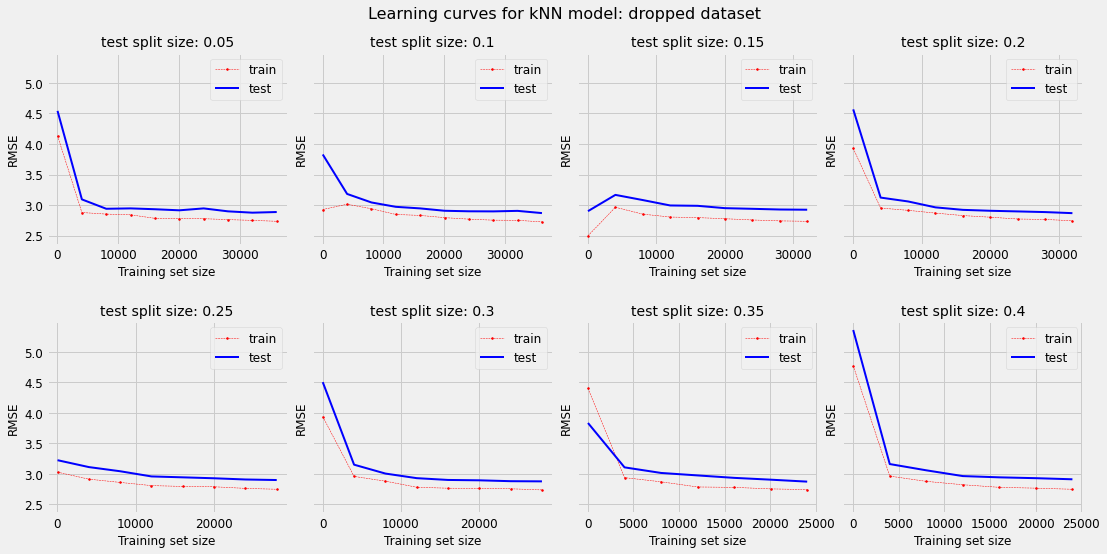

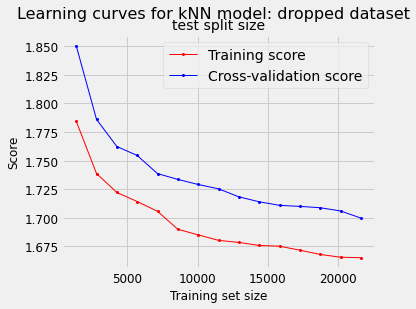

In [ ]:
plot_learning_curves(knn_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for kNN model: dropped dataset', plot_name='knn_dropped', start_size=best_knn_dropped['param_knn__n_neighbors'].values[0]*2, scale=3000)

plot_learning_curve(knn_dropped, X_dropped, y_dropped_nums,'Learning curves for kNN model: dropped dataset', plot_name='knn_dropped')

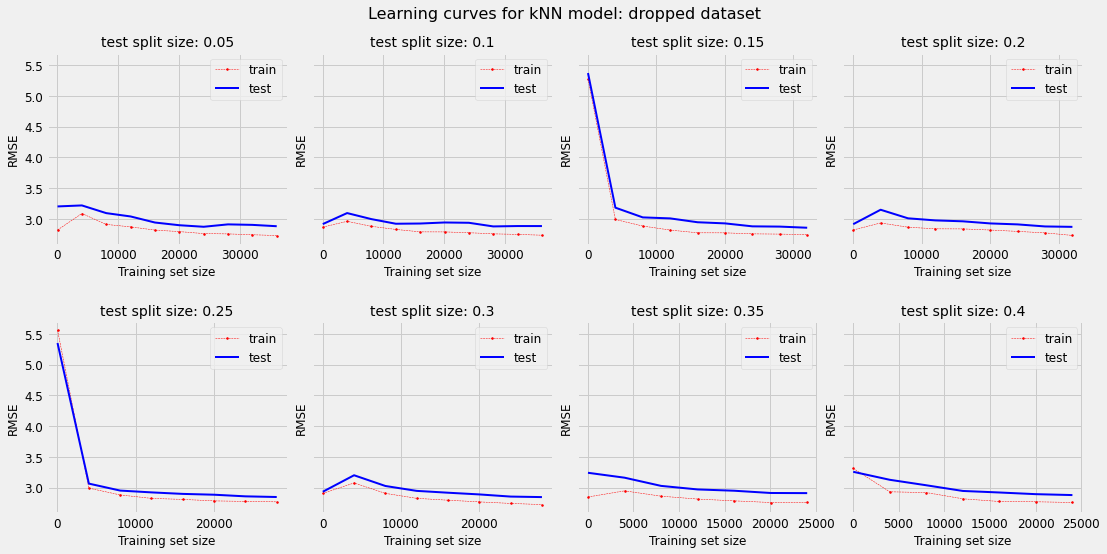

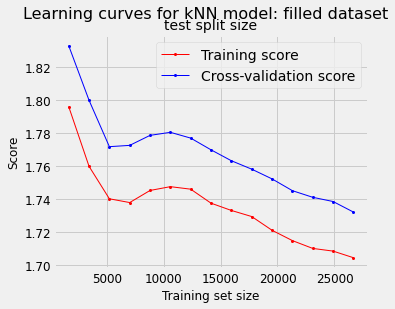

In [ ]:
plot_learning_curves(knn_dropped, X_dropped, y_dropped_nums,'Learning curves for kNN model: dropped dataset', plot_name='knn_dropped', start_size=best_knn_dropped['param_knn__n_neighbors'].values[0]*2, scale=4000)

plot_learning_curve(knn_filled, X_filled, y_filled_nums,
                     'Learning curves for kNN model: filled dataset', plot_name='knn_filled')

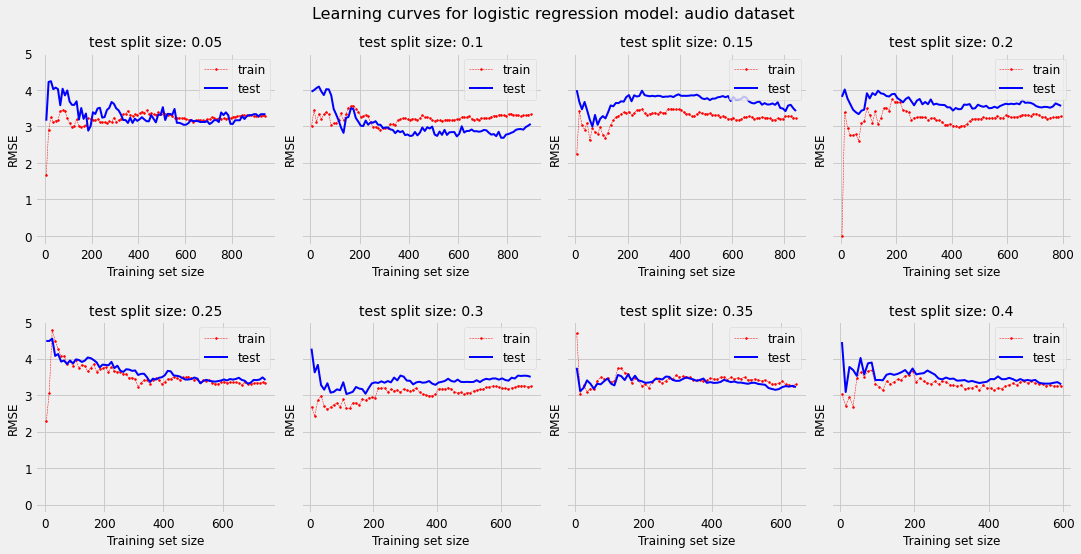

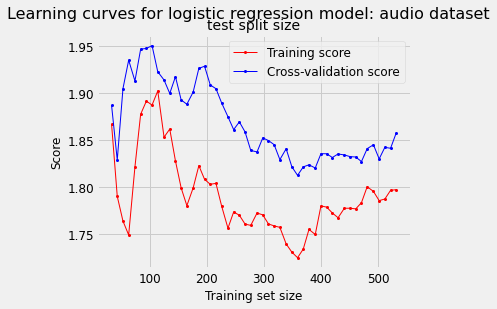

In [ ]:
plot_learning_curves(logreg_audio, X_audio, y_audio_nums,
                     'Learning curves for logistic regression model: audio dataset', plot_name='logreg_audio',start_size=5)

# plot_learning_curve(logreg_audio, X_audio, y_audio_nums,
#                      'Learning curves for logistic regression model: audio dataset', plot_name='logreg_audio', splits=50)


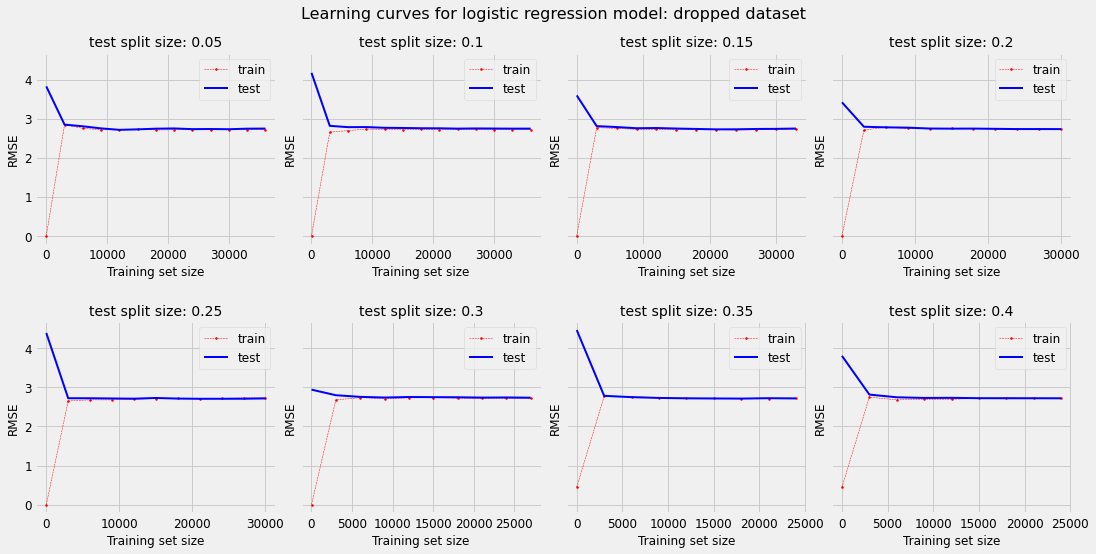

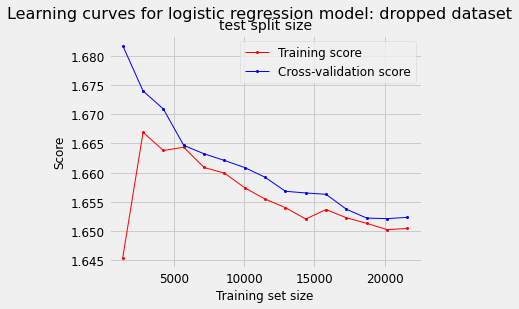

In [ ]:
plot_learning_curves(logreg_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for logistic regression model: dropped dataset', plot_name = 'logreg_dropped',scale=3000)
                     
# plot_learning_curve(logreg_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for logistic regression model: dropped dataset', plot_name='logreg_dropped')


/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

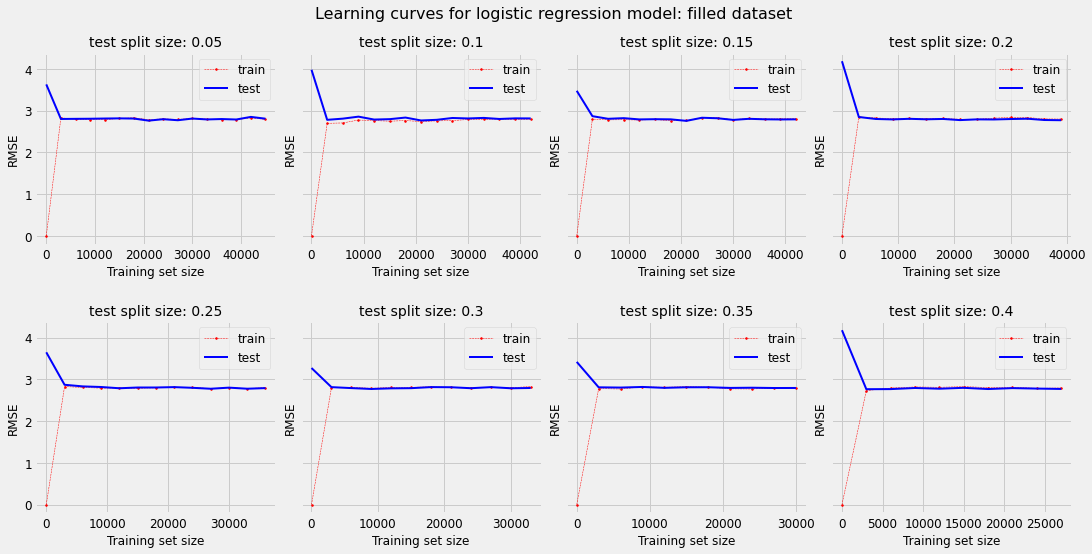

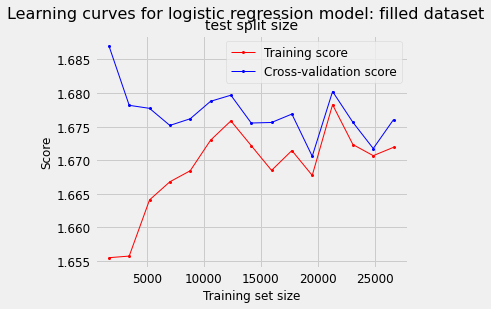

In [ ]:
plot_learning_curves(logreg_filled, X_filled, y_filled_nums,
                     'Learning curves for logistic regression model: filled dataset', plot_name='logreg_filled', scale=3000)

# plot_learning_curve(logreg_filled, X_filled, y_filled_nums,
#                      'Learning curves for logistic regression model: filled dataset', plot_name='logreg_filled')

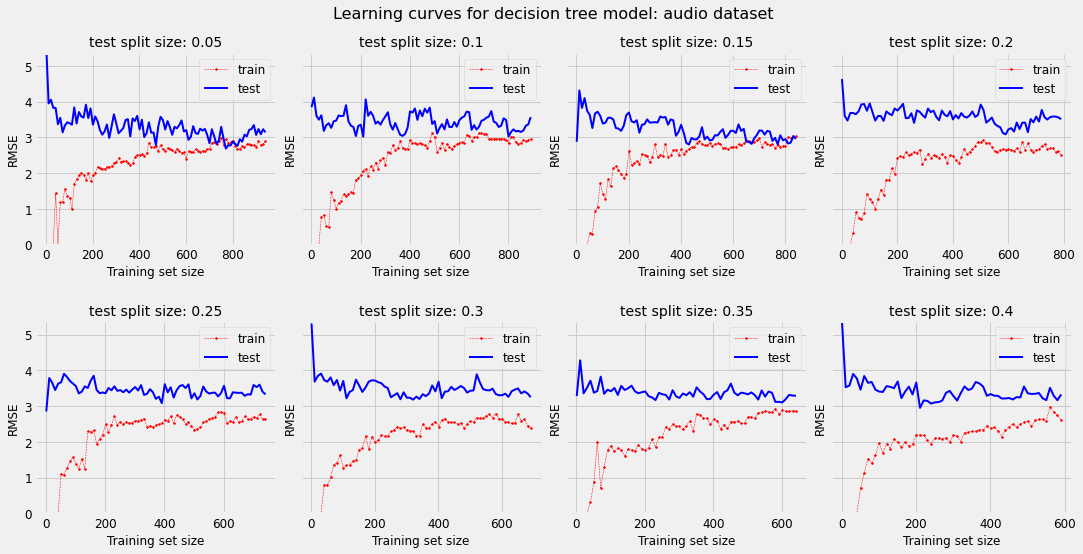

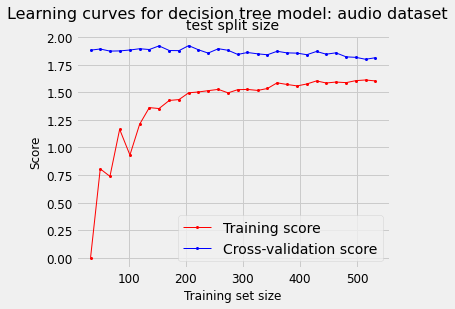

In [ ]:
plot_learning_curves(tree_audio, X_audio, y_audio_nums,
                     'Learning curves for decision tree model: audio dataset', plot_name = 'tree_audio')

# plot_learning_curve(tree_audio, X_audio, y_audio_nums,
#                      'Learning curves for decision tree model: audio dataset', plot_name='tree_audio', splits = 30)

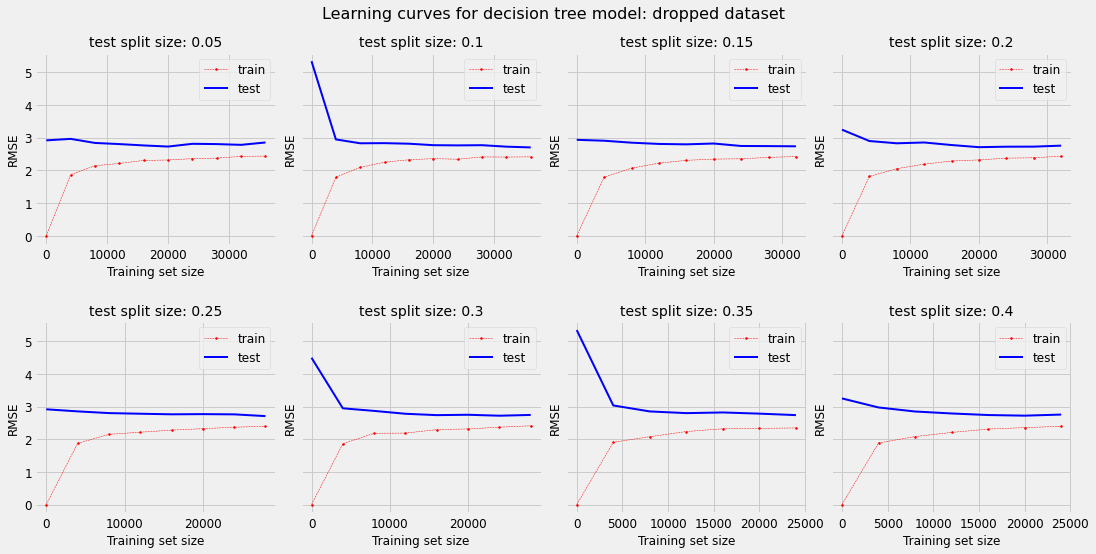

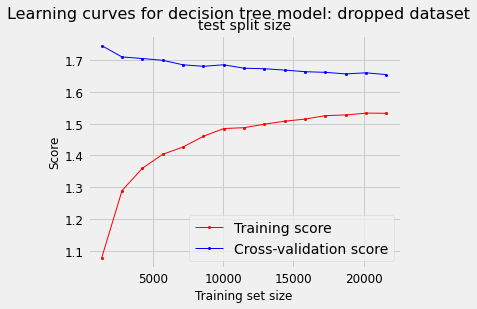

In [ ]:
plot_learning_curves(tree_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for decision tree model: dropped dataset', plot_name='tree_dropped', scale=4000)

# plot_learning_curve(tree_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for decision tree model: dropped dataset', plot_name='tree_dropped')

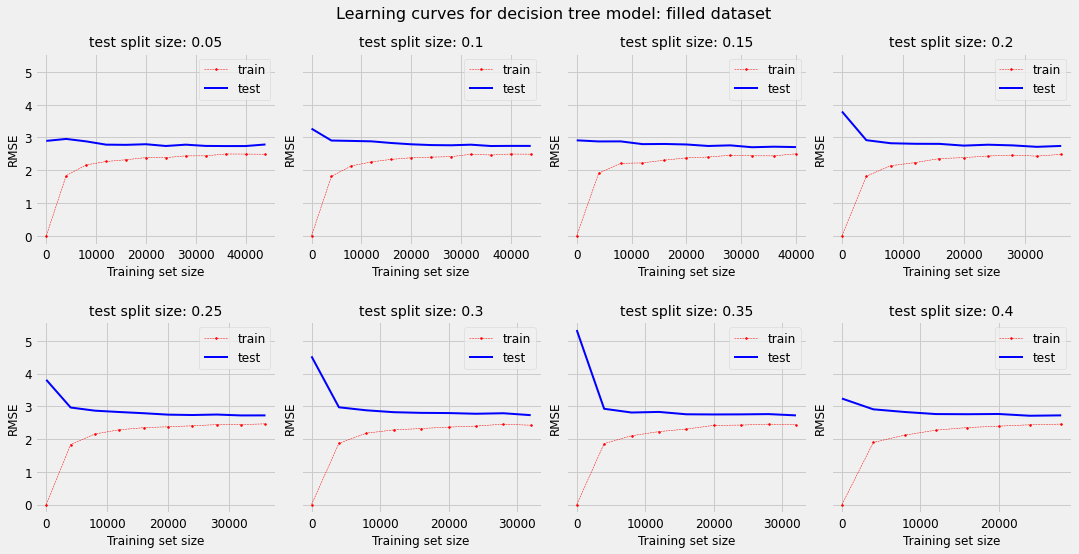

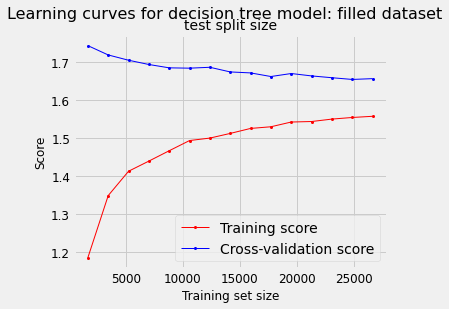

In [ ]:
plot_learning_curves(tree_filled, X_filled, y_filled_nums,
                     'Learning curves for decision tree model: filled dataset', plot_name = 'tree_filled', scale = 4000)

# plot_learning_curve(tree_filled, X_filled, y_filled_nums,
#                      'Learning curves for decision tree model: filled dataset', plot_name='tree_filled')


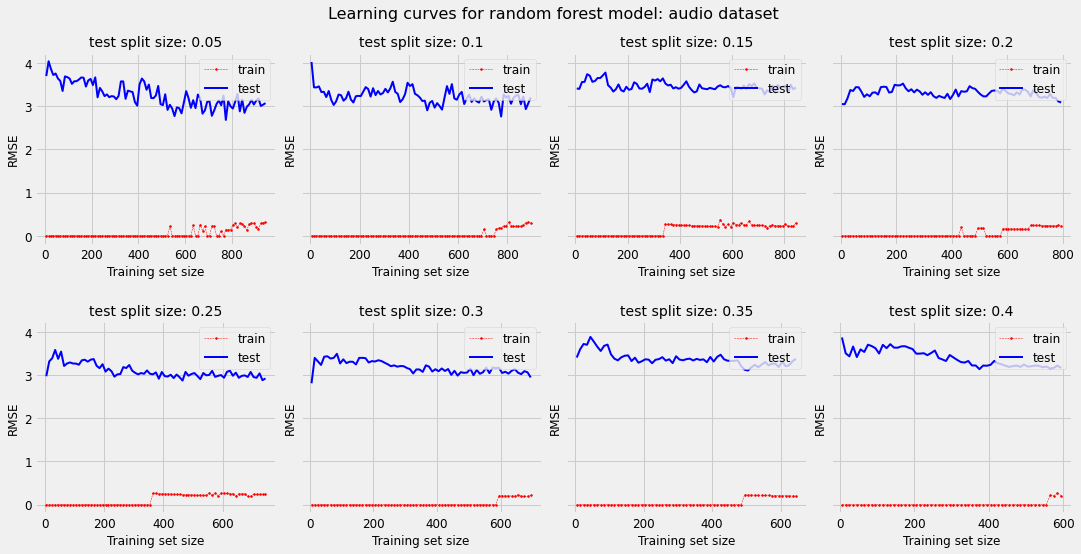

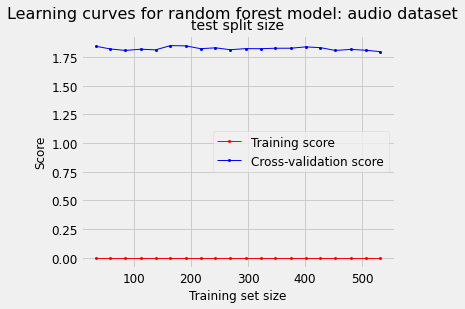

In [ ]:
plot_learning_curves(forest_audio, X_audio, y_audio_nums,
                     'Learning curves for random forest model: audio dataset', plot_name='forest_audio')

# plot_learning_curve(forest_audio, X_audio, y_audio_nums,
#                     'Learning curves for random forest model: audio dataset', plot_name='forest_audio', splits=20)


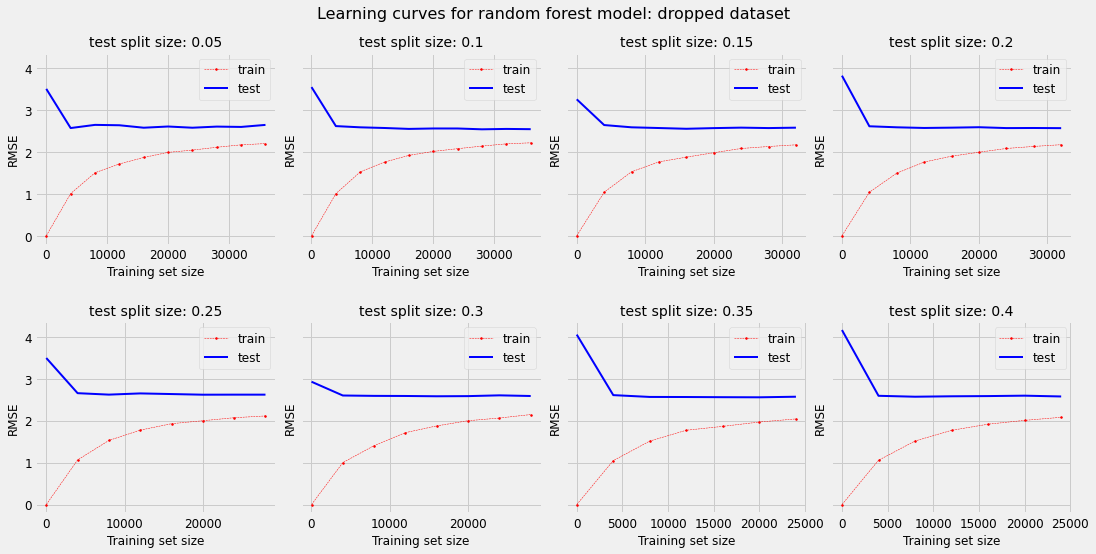

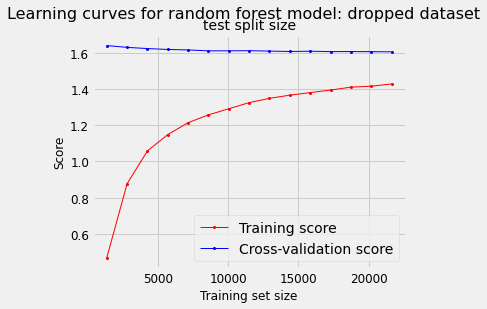

In [ ]:
plot_learning_curves(forest_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for random forest model: dropped dataset', plot_name='forest_dropped', scale=4000)

# plot_learning_curve(forest_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for random forest model: dropped dataset', plot_name = 'forest_dropped')

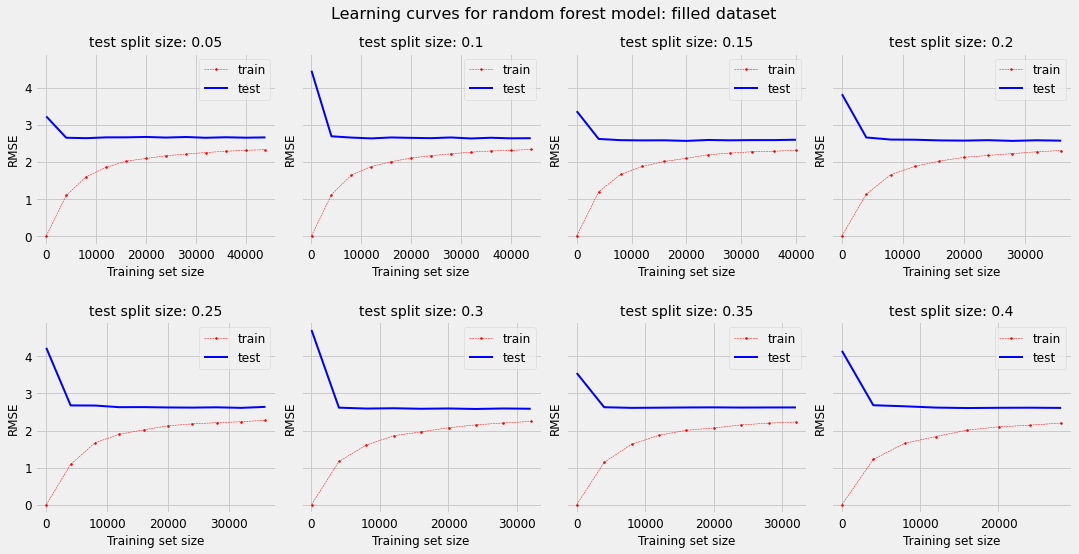

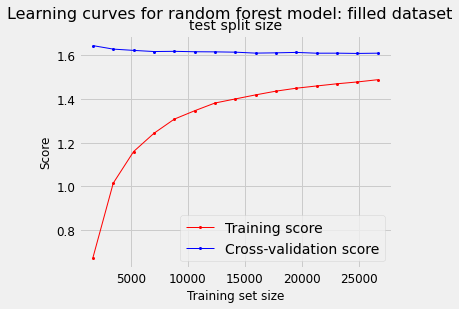

In [ ]:
plot_learning_curves(forest_filled, X_filled, y_filled_nums,
                     'Learning curves for random forest model: filled dataset', plot_name='forest_filled', scale=4000)

# plot_learning_curve(forest_filled, X_filled, y_filled_nums,
#                      'Learning curves for random forest model: filled dataset', plot_name='forest_filled')